In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypalettes import create_cmap
import matplotlib.colors as colors

In [2]:
rank_by_year = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-09-09/rank_by_year.csv")

In [3]:
rank_by_year.head(2)

,code,country,region,rank,visa_free_count,year
0,AF,Afghanistan,ASIA,116,26,2021
1,AF,Afghanistan,ASIA,106,26,2020


In [4]:
# List of EU countries
eu_list = ["Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark", "Estonia", "Finland", "France", "Germany", "Greece",
           "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Poland", "Portugal", "Romania",
           "Slovakia", "Slovenia", "Spain", "Sweden"]

In [5]:
# Select EU countries
df = rank_by_year[rank_by_year["country"].isin(eu_list)]

In [6]:
# Select years
df = df[df["year"].between(2014, 2025)]

In [7]:
# Group by country and sum up the visa free count
visa_counts = df.groupby("country", as_index=False)["visa_free_count"].sum()
# Rank countries based on visa free count
visa_counts["rank"] = visa_counts["visa_free_count"].rank(ascending=False).astype(int)
# Sort by rank 
country_rank = visa_counts.sort_values("rank")

In [8]:
country_rank.head(2)

,country,visa_free_count,rank
10,Germany,2218,1
8,Finland,2207,2


In [9]:
# Drop redundant columns before merging
df = df.drop("rank", axis=1)
country_rank = country_rank.drop("visa_free_count", axis=1)

In [10]:
# Merge df with rank df
df = pd.merge(df, country_rank, on="country", how="left")

In [11]:
# Sort values by rank and descending year
df = df.sort_values(by=["rank", "year"], ascending=[True, False]).reset_index()

In [12]:
df.head(2)

,index,code,country,region,visa_free_count,year,rank
0,131,DE,Germany,EUROPE,189,2025,1
1,130,DE,Germany,EUROPE,194,2024,1


In [13]:
# Create cmap
my_cmap = create_cmap(
    colors=["#efdec0", "#e9d2a8", "#e3c590", "#ddb877", "#d7ab5f", "#d19f46", "#cb922e"],
    cmap_type="continuous",
)

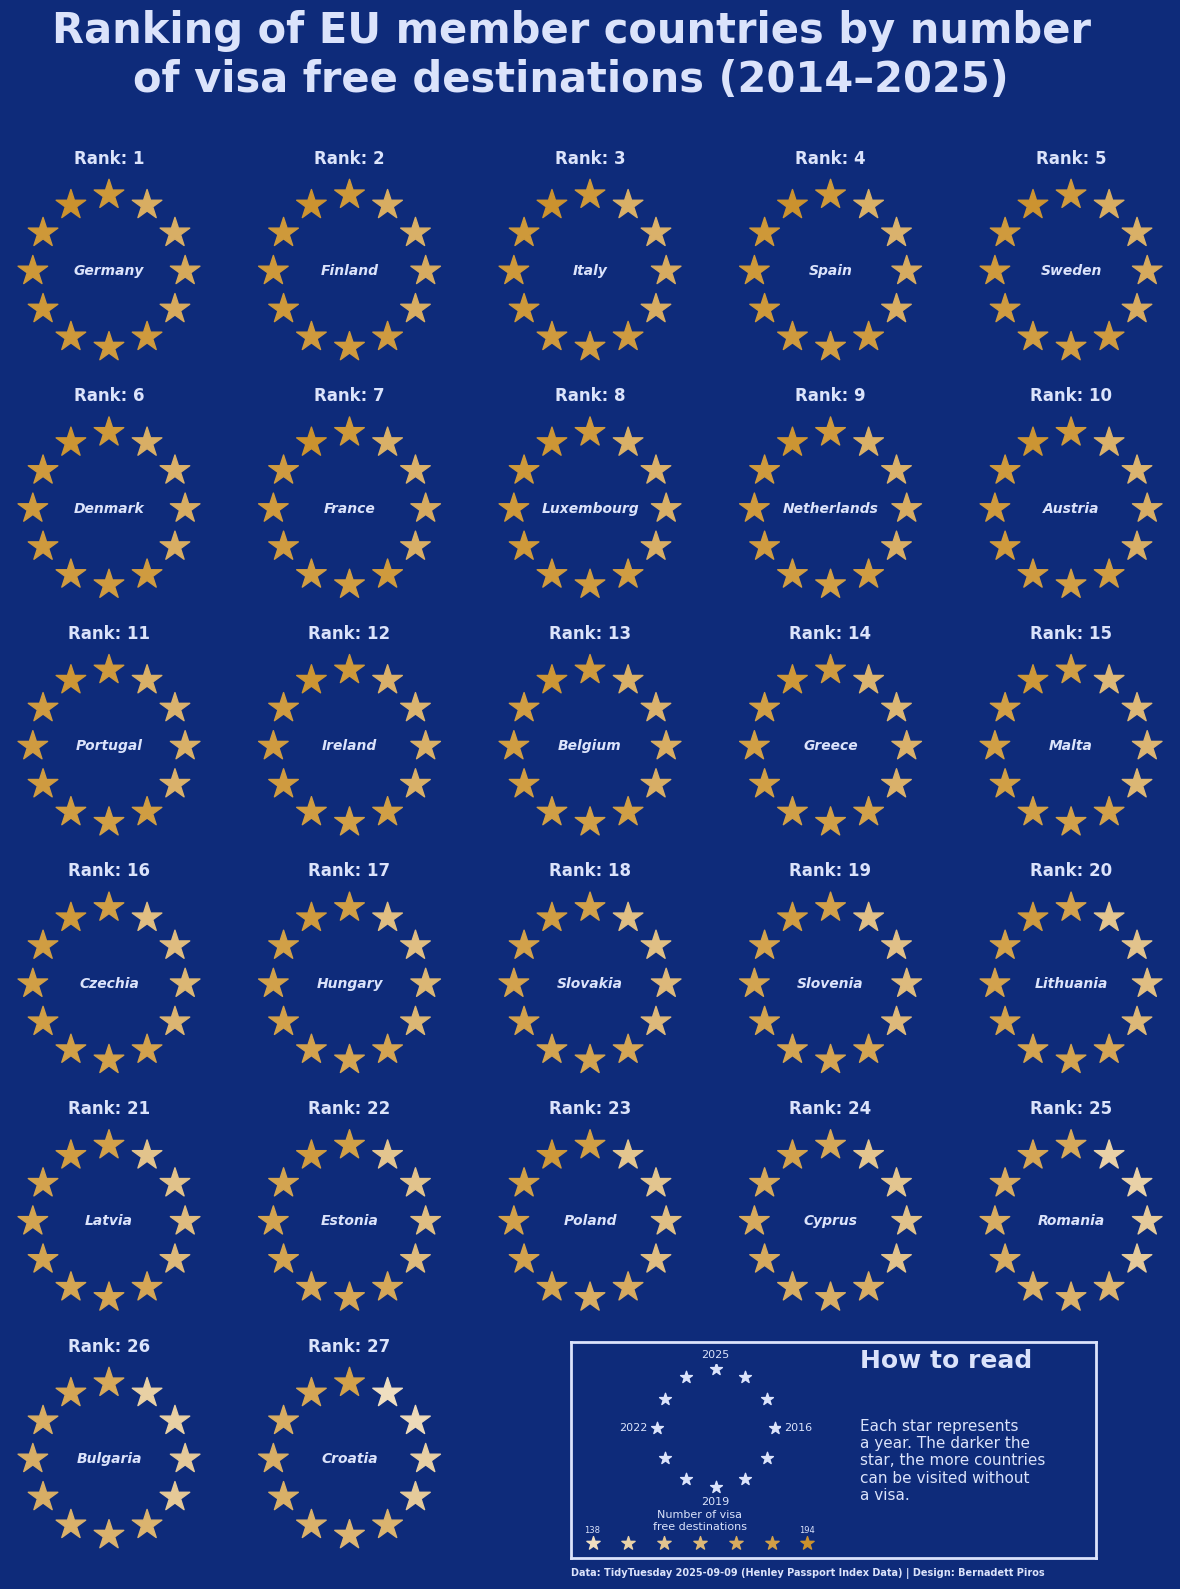

In [14]:
# Unique countries
countries = df["country"].unique()

# Parameters for circle with 12 stars
num_points = 12
angles = np.linspace(0, 2*np.pi, num_points, endpoint=False)[::-1] + (np.pi/2) # Latest year to 90°
radius = 1
x = radius * np.cos(angles)
y = radius * np.sin(angles)

# Normalize colors
norm = colors.Normalize(vmin=df["visa_free_count"].min(), vmax=df["visa_free_count"].max())

# Create figure and flatten axes
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15, 18), facecolor="#0e2b7a")
axes = axes.flatten()

# Subplot for each country with 12 years (stars) that are colored based on visa free count
for ax, country in zip(axes, countries):
    ax.set_aspect("equal")
    ax.axis("off")
    # Country data
    country_df = df[df["country"] == country].sort_values("year")
    color_values = country_df["visa_free_count"].values   
    # Colors for the stars
    colors_mapped = my_cmap(norm(color_values))
    # Scatter points
    ax.scatter(x, y, marker="*", s=500, color=colors_mapped)
    # Add rank title
    rank = country_df["rank"].iloc[0]
    ax.set_title(f"Rank: {rank}", fontsize=12, color="#dbe3fb", weight="bold")
    # Add country name in the center
    ax.text(0, 0, country, color="#dbe3fb", size=10,  weight="bold", style="italic", ha="center", va="center")
    # Axis limits
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)

# Remove empty plots
for i in [27, 28, 29]:
    axes[i].remove()

## Legend -------------------------------------

# Main inset_ax ------------------
inset_ax = fig.add_axes([0.5, 0.11, 0.35, 0.12])
inset_ax.text(0.55, 0.88, "How to read", fontsize=18, color="#dbe3fb", weight="bold")

# Colored frame for the legend
for spine in ["left", "top", "bottom", "right"]:
    inset_ax.spines[spine].set_color("#dbe3fb")
    inset_ax.spines[spine].set_linewidth(2)
    
# Remove ticks
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.set_facecolor("#0e2b7a")

# Star inset_ax -----------------
star_ax = inset_ax.inset_axes([0.07, 0.3, 0.41, 0.6])
star_ax.axis("off")
star_ax.set_aspect("equal")

child_angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False) + (np.pi / 2)
child_angles = angles[::-1]  
child_radius = 0.1
xc = child_radius * np.cos(child_angles)
yc = child_radius * np.sin(child_angles)
star_ax.scatter(xc, yc, marker="*", color="#dbe3fb", s=80)

# Labels for 90°, 0°, 270°, 180°
labels = [0, 3, 6, 9]  
for i in labels:
    # Reverse access because angles are reversed
    year_label = country_df["year"].iloc[-(i+1)]  
    star_ax.text(xc[i] * 1.4, yc[i] * 1.25, str(year_label), color="#dbe3fb", size=8, ha="center", va="center")

# Color inset_ax -------------------
color_ax = inset_ax.inset_axes([0.02, 0.02, 0.45, 0.1])
color_ax.axis("off")

num_stars = 7
pos = np.linspace(0.02, 1, num_stars)
colors = [my_cmap(i / (num_stars - 1)) for i in range(num_stars)]
min_count = df["visa_free_count"].min()
max_count = df["visa_free_count"].max()

for i, (x, color) in enumerate(zip(pos, colors)):
    color_ax.scatter(x, 0, marker="*", color=color, s=100)
    # Min and max labels
    if i == 0:
        color_ax.text(x, 0.04, f"{min_count}", color="#dbe3fb", ha="center", va="bottom", fontsize=6)
    elif i == num_stars - 1:
        color_ax.text(x, 0.04, f"{max_count}", color="#dbe3fb", ha="center", va="bottom", fontsize=6)
        
color_ax.set_title("Number of visa\nfree destinations", color="#dbe3fb", size=8, ha="center", va="center")

# Text inset_ax -------------------------
text_ax = inset_ax.inset_axes([0.55, 0.05, 0.43, 0.8])
text_ax.axis("off")
text_ax.text(0, 0.5, "Each star represents\na year. The darker the\nstar, the more countries\ncan be visited without\na visa.", color="#dbe3fb", size=11, va="center")

# Texts
fig.text(0.5, 0.97, "Ranking of EU member countries by number\nof visa free destinations (2014–2025)", color="#dbe3fb", size=30, weight="bold", ha="center", va="top")
fig.text(0.5, 0.1, "Data: TidyTuesday 2025-09-09 (Henley Passport Index Data) | Design: Bernadett Piros", size=7, color="#dbe3fb", weight="bold")

plt.show()

#fig.savefig("2025-09-09.png", bbox_inches='tight', pad_inches=0.2)